In [11]:
import cv2
import os
import glob

# Set the directory where your images are located
image_folder = './'
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
video_name = 'density.mp4'

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1'
video = cv2.VideoWriter(video_name, fourcc, 20, (width, height))

# Sort the file names if necessary
images.sort()  # Sort the images by name (this is optional and may depend on your naming convention)

# Append the images to the video
for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# Release the video writer
cv2.destroyAllWindows()
video.release()


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py

In [3]:
f = h5py.File("snapshot_120.hdf5",'r')

In [24]:
scale_factor        = f['Header'].attrs['Time']
h_factor            = f['Header'].attrs['HubbleParam']
unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']

# Calculate the position and the velocity of the center of mass

gas_coord   = f['PartType0']['Coordinates'][:]
gas_vel     = f['PartType0']['Velocities'][:]
gas_mass    = f['PartType0']['Masses'][:]

coord   = gas_coord * scale_factor * unit_length_cgs
vel     = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
mass    = gas_mass * unit_mass_cgs

pos_com = np.zeros(3)
vel_com = np.zeros(3)

for i in range(3):
    pos_com[i] = np.sum( coord[:, i]* mass ) / np.sum( mass )
    vel_com[i] = np.sum( vel[:, i]  * mass ) / np.sum( mass )

pos_com, vel_com

(array([ 1.74350017e+20, -1.46690697e+19,  1.79740520e+20]),
 array([-34832.17118578,   1845.71840302, 111041.42305939]))

In [5]:
Time = f['Header'].attrs['Time']

In [5]:
font = {'family': 'serif',
#         'color':  'dark',
        'weight': 'normal',
        'size': 10,
        }

In [6]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.constants import G
import numpy as np

def Virial_Radius( halo_mass, redshift):
    # Example values
    halo_mass = halo_mass * u.g  # Halo mass
    overdensity = 200  # Overdensity factor

    # Calculate critical density of the universe at given redshift
    critical_density = cosmo.critical_density(redshift)

    # Calculate the virial radius
    # M = (4/3) * pi * R_vir^3 * Delta * rho_c
    # Rearranging for R_vir:
    virial_radius = ((3 * halo_mass) / (4 * np.pi * overdensity * critical_density))**(1/3)

    return virial_radius.value

In [21]:
cosmo.critical_density(20)

<Quantity 2.4912698e-26 g / cm3>

In [16]:
def Mass_Shells( coord, mass, num_bins ):
    # Calculate the distance from the center of mass
    dist = np.sqrt( np.sum( (coord - pos_com)**2, axis=1 ) )

    # Calculate the virial radius
    max_radius = max( dist )

    # Calculate the bin edges
    bin_edges = np.linspace( 0, max_radius, num_bins + 1 )

    # Calculate the mass in each shell
    mass_in_shells, bin_edges = np.histogram( dist, bins=bin_edges, weights=mass )

    # Calculate the mass in each shell
    mass_in_shells = mass_in_shells * u.g

    # Calculate the volume of each shell
    shell_volume = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

    # Calculate the density in each shell
    density_in_shells = mass_in_shells.value / shell_volume

    return density_in_shells, bin_edges

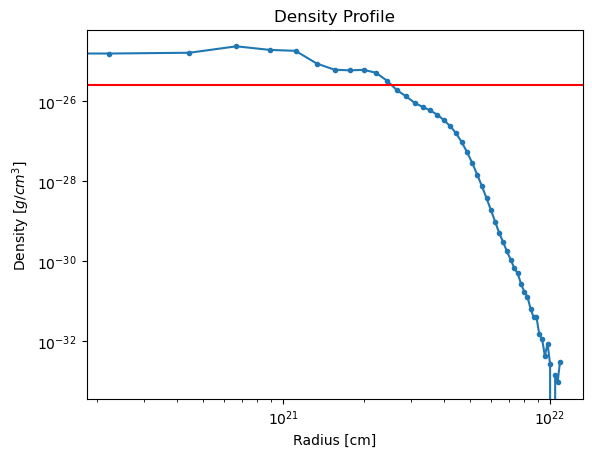

In [36]:
import numpy as np
import matplotlib.pyplot as plt

num_bins = 50
density_profile, bins = Mass_Shells( coord, mass, num_bins )

# Plot the density profile
plt.plot(bins[:-1], density_profile, marker='.' )
plt.axhline(y = cosmo.critical_density(20).value, color = 'r', linestyle = '-', label='label') 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [cm]')
plt.ylabel('Density [$g/cm^3$]')
plt.title('Density Profile')
plt.show()


In [35]:
# Print the radius where the density profile is equal to the critical density
print( bins[ np.where( density_profile > cosmo.critical_density(20).value )[0][-1] ] / u.kpc.to(u.cm) )

0.79244868347802


In [5]:
# Calculate the spin parameter across all snapshots

spin_set = []
r_half_set = []
time_set = []

N_i = 12
N_f = 140
for i in range(N_i, N_f):
    # Constants
    G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
    G = G * (100)**3 / 1000 # to cgs

    f = h5py.File( "snapshot_%03d.hdf5" % i )

    scale_factor        = f['Header'].attrs['Time']
    h_factor            = f['Header'].attrs['HubbleParam']
    unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
    unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
    unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']

    gas_coord   = f['PartType0']['Coordinates'][:] 
    gas_vel     = f['PartType0']['Velocities'][:]
    gas_mass    = f['PartType0']['Masses'][:]

    coord   = gas_coord * scale_factor * unit_length_cgs
    vel     = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
    mass    = gas_mass * unit_mass_cgs

    # Example particle data (replace with your data)
    x, y, z = coord[:,0], coord[:,1], coord[:,2]
    vx, vy, vz = vel[:,0], vel[:,1], vel[:,2]

    # num_bins = 100
    # mass_in_shells, shell_volumes, bins = Mass_Shells( coord, mass, num_bins )

    # Total mass
    M = np.sum(mass)

    # Center of mass
    CM_x = np.sum(x * mass) / M
    CM_y = np.sum(y * mass) / M
    CM_z = np.sum(z * mass) / M

    # Position and velocity relative to center of mass
    rel_x = x - CM_x
    rel_y = y - CM_y
    rel_z = z - CM_z
    rel_vx = vx - np.mean(vx)
    rel_vy = vy - np.mean(vy)
    rel_vz = vz - np.mean(vz)

    # Angular momentum for each particle
    lx = rel_y * rel_vz - rel_z * rel_vy
    ly = rel_z * rel_vx - rel_x * rel_vz
    lz = rel_x * rel_vy - rel_y * rel_vx

    # Total angular momentum
    Lx = np.sum(lx * mass)
    Ly = np.sum(ly * mass)
    Lz = np.sum(lz * mass)
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2)

    # Assuming you have the virial radius R
    # R = half_mass_radius( mass_in_shells, num_bins, bins )
    halo_mass = np.sum( f['PartType0']['Masses'][:] ) + np.sum( f['PartType1']['Masses'][:] ) * unit_mass_cgs
    R = Virial_Radius( halo_mass, 1/scale_factor-1)

    # Circular velocity at R
    V = np.sqrt(G * M / R)

    # Spin parameter
    lambda_spin = L / (np.sqrt(2) * M * R * V)

    spin_set.append( lambda_spin )
    r_half_set.append( R / 3.08e21 )
    time_set.append( 1/scale_factor - 1 )

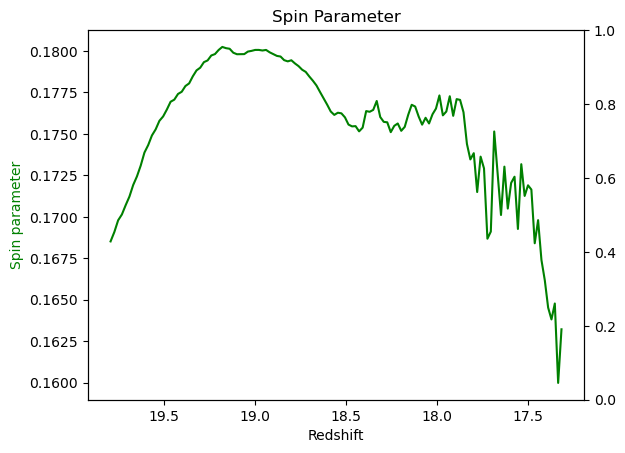

In [6]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( time_set , spin_set, 'g-' )
ax1.invert_xaxis()
# ax2.plot( time_set , np.array(r_half_set) / 3.08e21, 'b-' )
# ax2.invert_xaxis()

ax1.set_xlabel('Redshift')
ax1.set_ylabel('Spin parameter', color='g')
# ax2.set_ylabel('Virial radius [kpc]', color='b')

plt.title('Spin Parameter')
plt.show()

In [7]:
np.shape( time_set )

(35,)

In [38]:
# Calculate the energy of the particles

total_energy        = []
potential_energy    = []
kinetic_energy      = []
internel_energy     = []
time_set = []

N_i = 12
N_f = 147
for i in range(N_i, N_f):
    # Constants
    G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
    G *= (100)**3 / 1000 # to cgs    

    f = h5py.File( "snapshot_%03d.hdf5" % i )

    scale_factor        = f['Header'].attrs['Time']
    h_factor            = f['Header'].attrs['HubbleParam']
    unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
    unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
    unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']

    gas_coord   = f['PartType0']['Coordinates'][:] 
    gas_vel     = f['PartType0']['Velocities'][:]
    gas_mass    = f['PartType0']['Masses'][:]

    coord   = gas_coord * scale_factor * unit_length_cgs
    vel     = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
    mass    = gas_mass * unit_mass_cgs

    # Example particle data (replace with your data)
    x, y, z = coord[:,0], coord[:,1], coord[:,2]
    vx, vy, vz = vel[:,0], vel[:,1], vel[:,2]

    # Total mass
    M = np.sum(mass)

    # Center of mass
    CM_x = np.sum(x * mass) / M
    CM_y = np.sum(y * mass) / M
    CM_z = np.sum(z * mass) / M

    # Position and velocity relative to center of mass
    rel_x = x - CM_x
    rel_y = y - CM_y
    rel_z = z - CM_z
    rel_vx = vx - np.mean(vx)
    rel_vy = vy - np.mean(vy)
    rel_vz = vz - np.mean(vz)

    # radius within 3 ckpc/h
    distance = np.sqrt( rel_x**2 + rel_x**2 + rel_z**2)
    r_offset = 3 * scale_factor * unit_length_cgs
    ind = np.where(distance < r_offset)[0]

    # Calculate the potential_energy
    P = np.sum(f['PartType0']['Potential'][:][ind] * mass[ind] * unit_vel_cgs**2)

    # Calculate the kinetic_energy
    rel_v = np.sqrt(rel_vx**2 + rel_vy**2 + rel_vz**2)
    Ek = np.sum(1/2*mass[ind]*rel_v[ind]**2)

    # Calculate the internel_energy
    gas_intern = f['PartType0']['InternalEnergy'][:]
    Eu = np.sum(gas_intern[ind] * mass[ind] * unit_vel_cgs**2)

    # Use the above values to obtain the total energy
    E = P + Ek + Eu

    # Record the value across snapshots
    total_energy.append(E)
    potential_energy.append(-P)
    kinetic_energy.append(Ek)
    internel_energy.append(Eu)
    time_set.append( 1/scale_factor - 1 )

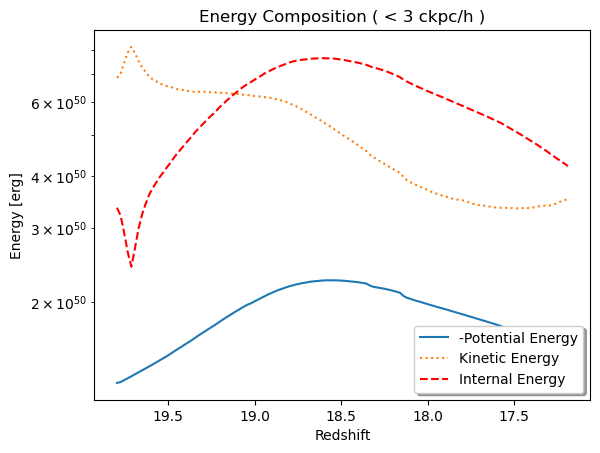

In [39]:
# Plot the energy profile
fig, ax = plt.subplots()
ax.plot(time_set, potential_energy  , '-'   , label='-Potential Energy')
ax.plot(time_set, kinetic_energy    , ':'   , label='Kinetic Energy')
ax.plot(time_set, internel_energy   , 'r--' , label='Internal Energy')
# ax.plot(time_set, potential_energy   , 'r.' , label='Potential Energy')
ax.invert_xaxis()

legend = ax.legend(loc=4, shadow=True)

plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel('Energy [erg]')

plt.title('Energy Composition ( < 3 ckpc/h )')
plt.show()